In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_accounts.csv
/kaggle/input/saas-subscription-and-churn-analytics-dataset/README.md
/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_feature_usage.csv
/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_support_tickets.csv
/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_subscriptions.csv
/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_churn_events.csv


In [2]:
# Install DuckDB (SQL engine)
!pip install duckdb --quiet

# Import DuckDB
import duckdb


In [3]:
import duckdb

# Connect to in-memory DuckDB
con = duckdb.connect()

# Load CSV files as SQL tables
con.execute("CREATE TABLE accounts AS SELECT * FROM '/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_accounts.csv'")
con.execute("CREATE TABLE subscriptions AS SELECT * FROM '/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_subscriptions.csv'")
con.execute("CREATE TABLE feature_usage AS SELECT * FROM '/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_feature_usage.csv'")
con.execute("CREATE TABLE support_tickets AS SELECT * FROM '/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_support_tickets.csv'")
con.execute("CREATE TABLE churn_events AS SELECT * FROM '/kaggle/input/saas-subscription-and-churn-analytics-dataset/ravenstack_churn_events.csv'")


In [4]:
# Preview the first 10 rows of the accounts table
con.execute("""
SELECT *
FROM accounts
LIMIT 10
""").fetchdf()


,account_id,account_name,industry,country,signup_date,referral_source,plan_tier,seats,is_trial,churn_flag
0,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False
1,A-43a9e3,Company_1,FinTech,IN,2023-08-17,other,Basic,18,False,True
2,A-0a282f,Company_2,DevTools,US,2024-08-27,organic,Basic,1,False,False
3,A-1f0ac7,Company_3,HealthTech,UK,2023-08-27,other,Basic,24,True,False
4,A-ce550d,Company_4,HealthTech,US,2024-10-27,event,Enterprise,35,False,True
5,A-1b9609,Company_5,EdTech,IN,2023-10-12,ads,Enterprise,4,False,False
6,A-a0ca4e,Company_6,Cybersecurity,US,2024-03-08,ads,Pro,11,False,False
7,A-e5d6ab,Company_7,EdTech,US,2023-04-15,partner,Pro,3,False,False
8,A-7dacce,Company_8,Cybersecurity,CA,2024-09-10,event,Enterprise,12,False,True
9,A-10b8da,Company_9,DevTools,US,2023-05-08,partner,Enterprise,14,False,True


In [5]:
# Preview the first 5 rows of the subscriptions table
con.execute("SELECT * FROM subscriptions LIMIT 5").fetchdf()


,subscription_id,account_id,start_date,end_date,plan_tier,seats,mrr_amount,arr_amount,is_trial,upgrade_flag,downgrade_flag,churn_flag,billing_frequency,auto_renew_flag
0,S-8cec59,A-3c1a3f,2023-12-23,2024-04-12,Enterprise,14,2786,33432,False,False,False,True,monthly,True
1,S-0f6f44,A-9b9fe9,2024-06-11,NaT,Pro,17,833,9996,False,False,False,False,monthly,True
2,S-51c0d1,A-659280,2024-11-25,NaT,Enterprise,62,0,0,True,True,False,False,annual,False
3,S-f81687,A-e7a1e2,2024-11-23,2024-12-13,Enterprise,5,995,11940,False,False,False,True,monthly,True
4,S-cff5a2,A-ba6516,2024-01-10,NaT,Enterprise,27,5373,64476,False,False,False,False,monthly,True


In [6]:
# Active subscribers per month
df_active = con.execute("""
WITH months AS (
    SELECT DISTINCT DATE_TRUNC('month', start_date) AS month
    FROM subscriptions
),
active_subs AS (
    SELECT
        account_id,
        start_date,
        end_date
    FROM subscriptions
)
SELECT
    m.month,
    COUNT(DISTINCT a.account_id) AS active_subscribers
FROM months m
LEFT JOIN active_subs a
    ON a.start_date <= m.month
    AND (a.end_date IS NULL OR a.end_date >= m.month)
GROUP BY m.month
ORDER BY m.month
""").fetchdf()

df_active


,month,active_subscribers
0,2023-01-01,0
1,2023-02-01,2
2,2023-03-01,10
3,2023-04-01,21
4,2023-05-01,37
5,2023-06-01,50
6,2023-07-01,71
7,2023-08-01,90
8,2023-09-01,117
9,2023-10-01,131


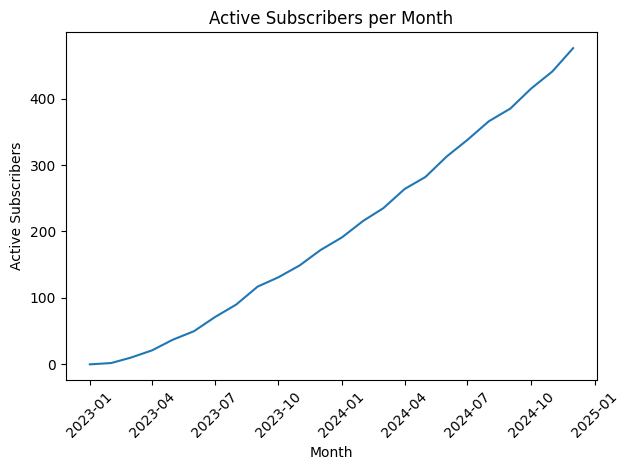

In [7]:
# Active subscribers plot
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_active["month"], df_active["active_subscribers"])
plt.title("Active Subscribers per Month")
plt.xlabel("Month")
plt.ylabel("Active Subscribers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
# Monthly churn rate
con.execute("""
WITH months AS (
    SELECT DISTINCT DATE_TRUNC('month', start_date) AS month
    FROM subscriptions
),
active_accounts AS (
    SELECT
        account_id,
        start_date,
        end_date
    FROM subscriptions
),
churned_accounts AS (
    SELECT
        account_id,
        DATE_TRUNC('month', churn_date) AS churn_month
    FROM churn_events
)
SELECT
    m.month,
    COUNT(DISTINCT c.account_id) AS churned_accounts,
    COUNT(DISTINCT a.account_id) AS active_accounts_start,
    ROUND(
        100.0 * COUNT(DISTINCT c.account_id) / NULLIF(COUNT(DISTINCT a.account_id),0),
        2
    ) AS churn_rate_percent
FROM months m
LEFT JOIN active_accounts a
    ON a.start_date <= m.month
    AND (a.end_date IS NULL OR a.end_date >= m.month)
LEFT JOIN churned_accounts c
    ON c.churn_month = m.month
GROUP BY m.month
ORDER BY m.month
""").fetchdf()



,month,churned_accounts,active_accounts_start,churn_rate_percent
0,2023-01-01,1,0,NaN
1,2023-02-01,0,2,0.00
2,2023-03-01,5,10,50.00
3,2023-04-01,3,21,14.29
4,2023-05-01,3,37,8.11
5,2023-06-01,5,50,10.00
6,2023-07-01,6,71,8.45
7,2023-08-01,6,90,6.67
8,2023-09-01,6,117,5.13
9,2023-10-01,10,131,7.63


In [9]:
# Monthly churn
df_churn = con.execute("""
SELECT
    DATE_TRUNC('month', churn_date) AS month,
    COUNT(DISTINCT account_id) AS churned_accounts
FROM churn_events
GROUP BY 1
ORDER BY 1
""").fetchdf()

df_churn


,month,churned_accounts
0,2023-01-01,1
1,2023-03-01,5
2,2023-04-01,3
3,2023-05-01,3
4,2023-06-01,5
5,2023-07-01,6
6,2023-08-01,6
7,2023-09-01,6
8,2023-10-01,10
9,2023-11-01,11


In [10]:
#Monthly churn rate for visual
df_monthly_churn = df_active.merge(
    df_churn,
    on="month",
    how="left"
)

df_monthly_churn["churned_accounts"] = df_monthly_churn["churned_accounts"].fillna(0)

df_monthly_churn["churn_rate"] = (
    df_monthly_churn["churned_accounts"]
    / df_monthly_churn["active_subscribers"]
)

df_monthly_churn


,month,active_subscribers,churned_accounts,churn_rate
0,2023-01-01,0,1.0,inf
1,2023-02-01,2,0.0,0.000000
2,2023-03-01,10,5.0,0.500000
3,2023-04-01,21,3.0,0.142857
4,2023-05-01,37,3.0,0.081081
5,2023-06-01,50,5.0,0.100000
6,2023-07-01,71,6.0,0.084507
7,2023-08-01,90,6.0,0.066667
8,2023-09-01,117,6.0,0.051282
9,2023-10-01,131,10.0,0.076336


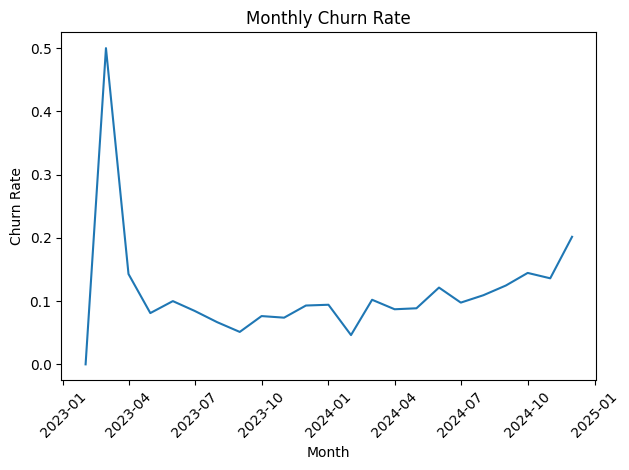

In [11]:
# Monthly churn rate plot
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_monthly_churn["month"], df_monthly_churn["churn_rate"])
plt.title("Monthly Churn Rate")
plt.xlabel("Month")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# Plan-level churn rate (overall)
df_plan_churn = con.execute("""
WITH active_accounts AS (
    SELECT
        account_id,
        plan_tier,
        start_date,
        end_date
    FROM subscriptions
),
churned_accounts AS (
    SELECT
        ce.account_id,
        s.plan_tier
    FROM churn_events ce
    LEFT JOIN subscriptions s
        ON ce.account_id = s.account_id
)
SELECT
    a.plan_tier,
    COUNT(DISTINCT c.account_id) AS churned_accounts,
    COUNT(DISTINCT a.account_id) AS active_accounts,
    ROUND(
        100.0 * COUNT(DISTINCT c.account_id)
        / NULLIF(COUNT(DISTINCT a.account_id), 0),
        2
    ) AS churn_rate_percent
FROM active_accounts a
LEFT JOIN churned_accounts c
    ON a.account_id = c.account_id
GROUP BY a.plan_tier
ORDER BY churn_rate_percent DESC
""").fetchdf()

df_plan_churn


,plan_tier,churned_accounts,active_accounts,churn_rate_percent
0,Basic,338,480,70.42
1,Enterprise,337,479,70.35
2,Pro,332,474,70.04


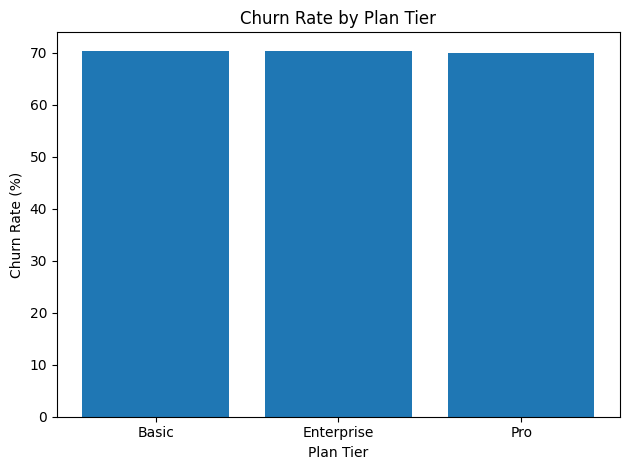

In [13]:
# Churn rate by plan tier plot
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    df_plan_churn["plan_tier"],
    df_plan_churn["churn_rate_percent"]
)
plt.title("Churn Rate by Plan Tier")
plt.xlabel("Plan Tier")
plt.ylabel("Churn Rate (%)")
plt.tight_layout()
plt.show()


In [14]:
# Feature adoption over time
df_feature_adoption = con.execute("""
SELECT
    DATE_TRUNC('month', fu.usage_date) AS month,
    fu.feature_name,
    COUNT(DISTINCT s.account_id) AS active_accounts
FROM feature_usage fu
JOIN subscriptions s
    ON fu.subscription_id = s.subscription_id
GROUP BY 1, 2
ORDER BY 1, 2
""").fetchdf()

df_feature_adoption


,month,feature_name,active_accounts
0,2023-01-01,feature_1,33
1,2023-01-01,feature_10,32
2,2023-01-01,feature_11,29
3,2023-01-01,feature_12,25
4,2023-01-01,feature_13,25
...,...,...,...
955,2024-12-01,feature_5,34
956,2024-12-01,feature_6,28
957,2024-12-01,feature_7,31
958,2024-12-01,feature_8,27


In [15]:
# Top features
top_features = (
    df_feature_adoption
    .groupby("feature_name")["active_accounts"]
    .sum()
    .sort_values(ascending=False)
    .head(4)
    .index
)

top_features


Index(['feature_32', 'feature_12', 'feature_34', 'feature_2'], dtype='object', name='feature_name')

In [16]:
# Filter for top features only
df_feature_top = df_feature_adoption[
    df_feature_adoption["feature_name"].isin(top_features)
]


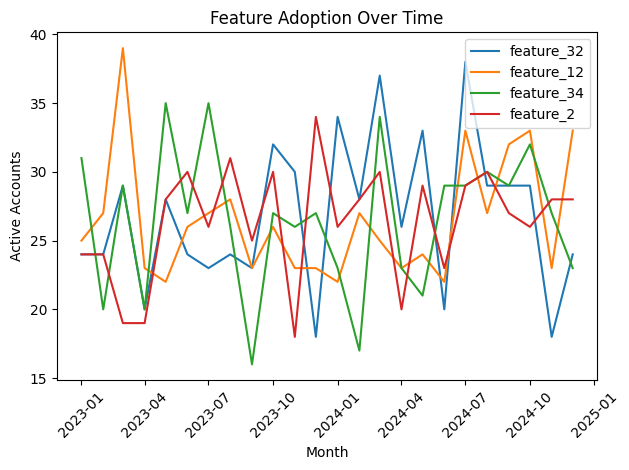

In [17]:
# Top feature adoption over time
import matplotlib.pyplot as plt

plt.figure()

for feature in top_features:
    subset = df_feature_top[df_feature_top["feature_name"] == feature]
    plt.plot(subset["month"], subset["active_accounts"], label=feature)

plt.title("Feature Adoption Over Time")
plt.xlabel("Month")
plt.ylabel("Active Accounts")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# Support tickets per account
df_support = con.execute("""
SELECT
    account_id,
    COUNT(*) AS ticket_count
FROM support_tickets
GROUP BY account_id
""").fetchdf()

df_support


,account_id,ticket_count
0,A-712f1c,6
1,A-6f8ad2,4
2,A-72799b,2
3,A-157070,3
4,A-78f02b,4
...,...,...
487,A-c608c8,2
488,A-7f29a7,1
489,A-0158bb,1
490,A-71615e,1


In [19]:
# Churn flag per account
df_churn_flag = con.execute("""
SELECT
    account_id,
    1 AS churned
FROM churn_events
""").fetchdf()

df_churn_flag


,account_id,churned
0,A-c37cab,1
1,A-37f969,1
2,A-b07346,1
3,A-1e50e0,1
4,A-956988,1
...,...,...
595,A-702032,1
596,A-dbc825,1
597,A-0a282f,1
598,A-e5d6ab,1


In [20]:
# Combine support and churn
df_support_churn = df_support.merge(
    df_churn_flag,
    on="account_id",
    how="left"
)

df_support_churn["churned"] = df_support_churn["churned"].fillna(0)

df_support_churn


,account_id,ticket_count,churned
0,A-712f1c,6,1.0
1,A-6f8ad2,4,0.0
2,A-72799b,2,1.0
3,A-157070,3,1.0
4,A-157070,3,1.0
...,...,...,...
733,A-c608c8,2,1.0
734,A-7f29a7,1,1.0
735,A-0158bb,1,0.0
736,A-71615e,1,1.0


In [21]:
# Aggregate for visualization
df_support_summary = (
    df_support_churn
    .groupby("ticket_count")["churned"]
    .mean()
    .reset_index()
)

df_support_summary


,ticket_count,churned
0,1,0.675676
1,2,0.827273
2,3,0.816456
3,4,0.826667
4,5,0.840000
5,6,0.800000
6,7,0.621622
7,8,0.800000
8,9,0.500000
9,10,1.000000


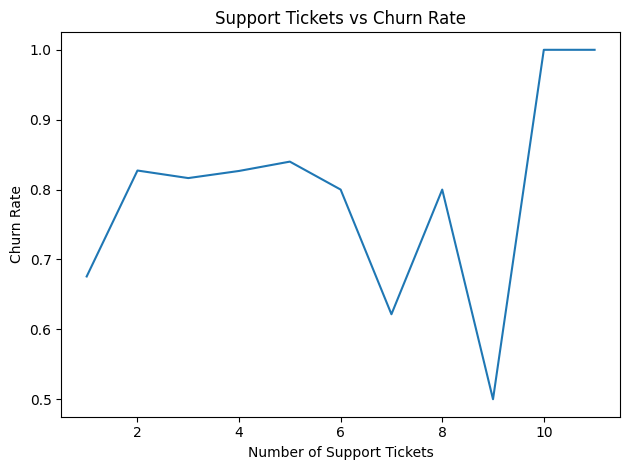

In [22]:
# Support tickets vs churn plot
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    df_support_summary["ticket_count"],
    df_support_summary["churned"]
)
plt.title("Support Tickets vs Churn Rate")
plt.xlabel("Number of Support Tickets")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()


In [23]:
# Support tickets vs churn
con.execute("""
WITH tickets_per_account AS (
    SELECT
        account_id,
        COUNT(*) AS tickets_count
    FROM support_tickets
    GROUP BY account_id
),
churn_status AS (
    SELECT
        account_id,
        1 AS churned
    FROM churn_events
)
SELECT
    t.tickets_count,
    COUNT(t.account_id) AS total_accounts,
    SUM(COALESCE(c.churned, 0)) AS churned_accounts,
    ROUND(100.0 * SUM(COALESCE(c.churned, 0)) / COUNT(t.account_id), 2) AS churn_rate_percent
FROM tickets_per_account t
LEFT JOIN churn_status c
    ON t.account_id = c.account_id
GROUP BY t.tickets_count
ORDER BY tickets_count
""").fetchdf()


,tickets_count,total_accounts,churned_accounts,churn_rate_percent
0,1,37,25.0,67.57
1,2,110,91.0,82.73
2,3,158,129.0,81.65
3,4,150,124.0,82.67
4,5,150,126.0,84.00
5,6,65,52.0,80.00
6,7,37,23.0,62.16
7,8,20,16.0,80.00
8,9,8,4.0,50.00
9,10,1,1.0,100.00
